In [11]:
from influxdb import InfluxDBClient
import pandas as pd
# required only for ploting
import matplotlib.pyplot as plt
%matplotlib inline 
from pylab import rcParams
rcParams['figure.figsize']= 15,6
from datetime import datetime

In [12]:
host = "138.246.232.174"
port = 8086
user = "root"
password = "root"
dbname = "memallocpycffi" #todo parameterize this

# make a dictionary of "dbname": "docker image name"
# limit to a 100-200 entries for plotting

imagedict = {
    'java-memory-leak':
        {
            'image': 'patrocinio/memoryleak:latest',
            'starttime': '2019-06-20T11:11:11.758Z',
            'endtime': '2019-06-20T12:19:26.758Z'
        },
    'new-python-basic-leak':
        {
            'image': 'poojakulkarni/basicpyleak:latest',
            'starttime': '2019-06-25T07:56:06.171Z',
            'endtime': '2019-06-25T08:56:51.171Z'
        },
    'memallocpycffi':
        {
            'image':'poojakulkarni/memallocpyleak:latest',
            'starttime': '2019-06-23T13:55:20.621Z',
            'endtime': '2019-06-23T15:00:50.621Z'
        },
    'new-nodejs-basic-leak':
        {
            'image': 'poojakulkarni/nodejsbasicleak:latest',
            'starttime': '2019-06-25T12:40:41.867Z',
            'endtime': '2019-06-25T13:40:51.867Z'
        },
    'new-nodejs-event-emitter-leak':
        {
            'image':'poojakulkarni/nodejseventemitterleak:latest',
            'starttime':'2019-06-25T15:08:43.672Z',
            'endtime': '2019-06-25T16:11:38.672Z'
        },
    'java-memory-leak-fix':
        {
            'image': 'poojakulkarni/javamemleakfix:latest',
            'starttime': '2019-06-25T21:19:16.569Z',
            'endtime': '2019-06-25T22:21:31.57Z'
        },
    'python-basic-leak-fix':
        {
            'image': 'poojakulkarni/pythonbasicleakfix:latest',
            'starttime': '',
            'endtime': ''
        },
    'nodejs-basic-leak-fix':
        {
            'image': 'poojakulkarni/nodejsbasicfix:latest',
            'starttime': '2019-06-26T05:39:49.982Z',
            'endtime': '2019-06-26T06:40:29.982Z'
        },
    'nodejs-event-emitter-leak-fix':
        {
            'image':'poojakulkarni/nodejseventemitterfix:latest',
            'starttime':'2019-06-26T08:57:37.206Z',
            'endtime': '2019-06-26T10:06:07.206Z'
        }
}

In [13]:
def newCalculateDifferenceBetweenDatapoints(containerSec):
    firstRound = True
    last5thValue = 0
    last5thTimeStamp = 0
    every5thItem = 0
    results = {}
    for item in containerSec:
        # For getting every the rate of 30 seconds
        if firstRound:
            last5thValue = containerSec[item]
            last5thTimeStamp = item
            firstRound = False
        else:
            if every5thItem == 2:
                # Calculation
                # Cut the last 9 numbers away
                divider = item - last5thTimeStamp
                value = (containerSec[item] - last5thValue)
                # Save to the new map
                results[item] = (value / divider.total_seconds()) * 100
                # Reset with the existing values
                last5thValue = containerSec[item]
                last5thTimeStamp = item
                every5thItem = 0
        every5thItem = every5thItem + 1
    return results

def transformDicToArrays(containerSec):
    xresult = []
    yresult = []
    for item in containerSec:
        xresult.append(item)
        yresult.append(containerSec.get(item,1)/2)
    return xresult, yresult

In [14]:
def connect(dbname):
    client = InfluxDBClient(host, port, user, password, dbname)
    return client


def get_container_memory_usage(client):
    """
    prometheus query is as follows -
    sum by (name)(container_memory_usage_bytes{image!=“",container_label_org_label_schema_group=""})
    :return:
    """
    
    #total machine memory
    memTotalQ = "select value " \
                "from node_memory_MemTotal_bytes " \
                "where time >= \'" + imagedict[dbname]['starttime'] +"\' " + \
                "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"

    memTotal_rs = client.query(memTotalQ)
    memTotal = get_dataframe(memTotal_rs, "total")
    

    #Container memory usage

    containerMemUsageQ = "SELECT value as usage " \
                         "FROM container_memory_usage_bytes " \
                         "WHERE image=" + "\'" + imagedict[dbname]['image'] + "\' " + \
                         "AND container_label_org_label_schema_group='' " \
                         "AND time >= \'" + imagedict[dbname]['starttime'] +"\' " +\
                         "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"

    #print(containerMemUsageQ)
    containerMemUsage_rs = client.query(containerMemUsageQ)
    containerMemUsage = get_dataframe(containerMemUsage_rs, "usage")
    
    containerMemUsage['usage'] = (containerMemUsage['usage']/memTotal['total'].values[0])*100
    containerMemUsage['time']  = pd.to_datetime(containerMemUsage['time'])
    #print(containerMemUsage)


    return containerMemUsage


def get_host_memory_usage(client):
    """
    prometheus query:
    node_memory_MemTotal_bytes - (node_memory_MemFree_bytes+node_memory_Buffers_bytes+node_memory_Cached_bytes)
    :return:
    """
    #total memory
    memTotalQ = "select value " \
                "from node_memory_MemTotal_bytes " \
                "where time >= \'" + imagedict[dbname]['starttime'] +"\' " + \
                "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"

    memTotal_rs = client.query(memTotalQ)
    memTotal = get_dataframe(memTotal_rs, "total")

    #free memory
    memFreeQ = "select value " \
               "from node_memory_MemFree_bytes " \
               "where time >= \'" + imagedict[dbname]['starttime'] +"\' " + \
               "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"

    memFree_rs = client.query(memFreeQ)
    memFree = get_dataframe(memFree_rs, "free")

    #buffered
    memBufferQ = "select value " \
                 "from node_memory_Buffers_bytes " \
                 "where time >= \'" + imagedict[dbname]['starttime'] + "\' " + \
                 "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"
    memBuffer_rs = client.query(memBufferQ)
    memBuffer = get_dataframe(memBuffer_rs, "buffer")

    #cached
    memCachedQ = "select value " \
                 "from node_memory_Cached_bytes " \
                 "where time >= \'" + imagedict[dbname]['starttime'] + "\' " + \
                 "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"

    memCached_rs = client.query(memCachedQ)
    memCache = get_dataframe(memCached_rs, "cache")

    #join dataframes for easier plotting
    tf_merge = pd.merge(memTotal, memFree, on="time")
    tfc_merge = pd.merge(tf_merge, memCache, on="time")
    tfcb_merge = pd.merge(tfc_merge, memBuffer, on="time")

    #add a column based on operation (used = total - {free+cache+buffer})
    tfcb_merge.apply(lambda row: row.total - (row.free + row.buffer + row.cache), axis=1)
    tfcb_merge['used'] = tfcb_merge.apply(
        lambda row: row.total - (row.free + row.buffer + row.cache),
        axis=1)
    tfcb_merge['time']  = pd.to_datetime(tfcb_merge['time'])
    tfcb_merge['used'] = (tfcb_merge['used']/memTotal['total'].values[0])*100
    # return final dataframe to plot

    return tfcb_merge


def get_container_cpu_usage(client):
    """
    sum by (name) (rate(container_cpu_usage_seconds_total{image!="",container_label_org_label_schema_group=""}[1m])) / scalar(count(node_cpu_seconds_total{mode="user"})) * 100

    :return:
    """
    
    q = "select value " \
        "from container_cpu_user_seconds_total " \
        "where image=" + "\'" + imagedict[dbname]['image'] \
        + "\'"\
        "AND time >= \'" + imagedict[dbname]['starttime'] + "\'"  \
        "AND time <= \'" + imagedict[dbname]['endtime'] + "\'" 
    
    qrs = client.query(q)

    containerCPUUserSecondsTotal = {}
    
    containerResult = qrs
    containerPoints = containerResult.get_points()

    for item in containerPoints:
        datetime_object = datetime.strptime(item['time'], '%Y-%m-%dT%H:%M:%S.%fZ')
        containerCPUUserSecondsTotal[datetime_object] = item['value']
        
    results = newCalculateDifferenceBetweenDatapoints(containerCPUUserSecondsTotal)
    xresult, yresult = transformDicToArrays(results)
    df = pd.DataFrame({'time':xresult, 'percentage':yresult})


    
    
    df['time']  = pd.to_datetime(df['time'])
    df_cut_xtreme = df
    return df_cut_xtreme


def get_host_cpu_usage(client):
    """
    sum(rate(container_cpu_user_seconds_total{image!=""}[1m])) / count(node_cpu_seconds_total{mode="user"}) * 100
sum(rate(node_cpu_seconds_total[1m])) by (mode) * 100 / scalar(count(node_cpu_seconds_total{mode="user"}))
    :return:
    """
    q = "SELECT value " \
        "FROM node_cpu_seconds_total " \
        "WHERE time >= \'" + imagedict[dbname]['starttime'] + "\'"  \
        "AND time <= \'" + imagedict[dbname]['endtime'] + "\'" \
        "AND mode='idle' "
    qrs = client.query(q)
    
        
    containerCPUUserSecondsTotal = {}
    
    containerResult = qrs
    containerPoints = containerResult.get_points()


    for item in containerPoints:
        datetime_object = datetime.strptime(item['time'], '%Y-%m-%dT%H:%M:%S.%fZ')
        containerCPUUserSecondsTotal[datetime_object] = item['value']
    
 
    results = newCalculateDifferenceBetweenDatapoints(containerCPUUserSecondsTotal)
    xresult, yresult = transformDicToArrays(results)
    df = pd.DataFrame({'time':xresult, 'percentage':yresult})

    df['percentage'] = 100 - df['percentage'] 
    
    
    df['time']  = pd.to_datetime(df['time'])
    df_cut_xtreme = df
    return df_cut_xtreme

def get_dataframe(query_resultset, valuename):
    qrs_json = query_resultset.raw
    np_list = qrs_json.get('series')[0].get('values')
    df = pd.DataFrame(np_list, columns=["time", valuename])
    return df



In [15]:
def plot_df(df, name, col_to_plot, ymax, ylabelle):
    """
    Plots the graph and saves the graph image in working dir
    :param df: dataframe to plot
    :param col_to_plot: specifies which metrics to plot
    :param name: name of the feature (used to save the plot locally)
    :param ymax: to limit percentage plots to 100 on y axis
    :param ylabelle : y label
    :return:
    """
    colors = ['blue', 'orange', 'red', 'grey', 'green', 'black', 'brown']
    ax = plt.gca()
    count = 0
    for col in col_to_plot:
        df.plot(kind='line', x="time", y=col, color=colors[count], ax=ax)
        count = count+1

    plt.title(name)
    plt.ylabel(ylabelle)
    #ax.tick_params(axis='x', rotation=16)
    plt.grid(True)
    plt.show()

    plt.clf()
    return

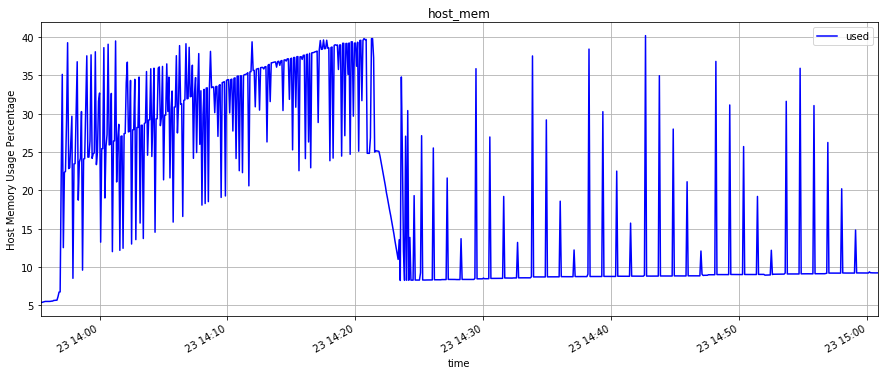

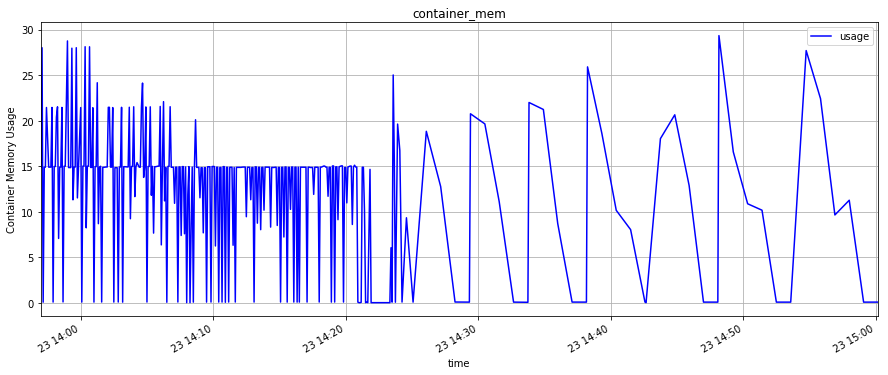

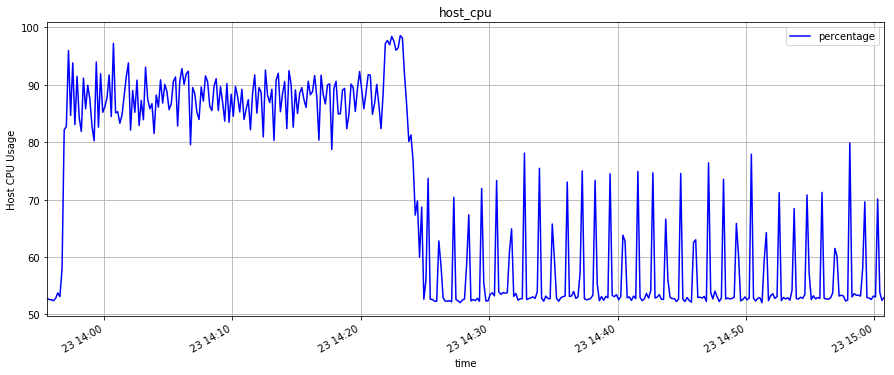

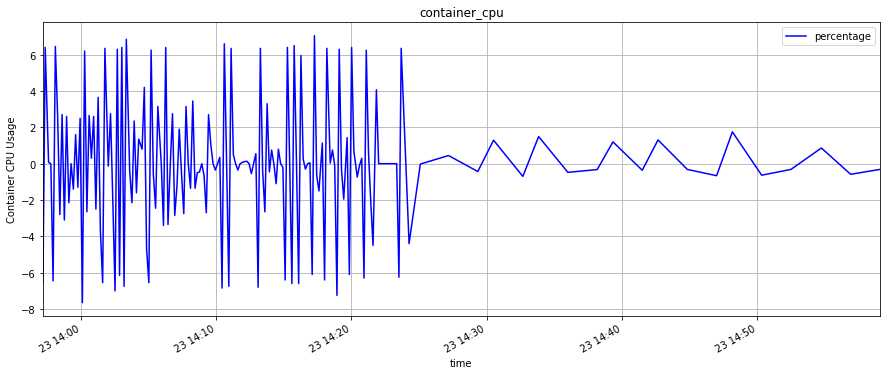

<Figure size 1080x432 with 0 Axes>

In [16]:
if __name__ == '__main__':
    #connect to the db
    # todo dbname must be parameterised to be passed as an argument
    client = connect(dbname)
    

    host_mem_used_df = get_host_memory_usage(client)
    plot_df(host_mem_used_df, "host_mem", ['used'], 0, "Host Memory Usage Percentage")

    container_mem_usage_df = get_container_memory_usage(client)
    plot_df(container_mem_usage_df, "container_mem", ['usage'], 0, "Container Memory Usage")

    host_cpu_usage = get_host_cpu_usage(client)
    plot_df(host_cpu_usage, "host_cpu", ['percentage'], 100, "Host CPU Usage")

    container_cpu_usage = get_container_cpu_usage(client)
    plot_df(container_cpu_usage, "container_cpu", ['percentage'], 0, "Container CPU Usage")